We have a bunch of probably chess x-corners output by our ML detector. Let's try to fit lines to them.

Populating the interactive namespace from numpy and matplotlib


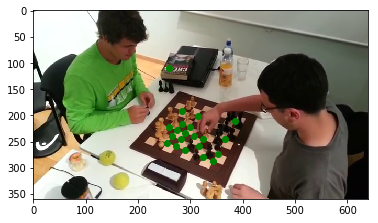

In [200]:
%pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
np.set_printoptions(suppress=True) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

img = PIL.Image.open('frame900.png')
gray = np.array(img.convert('LA'))

pts = np.loadtxt('example_pts.txt')
pts = pts[:,[1,0]] # Switch rows/cols to x/y for plotting on an image


plt.imshow(img)
plt.plot(pts[:,0],pts[:,1],'go');

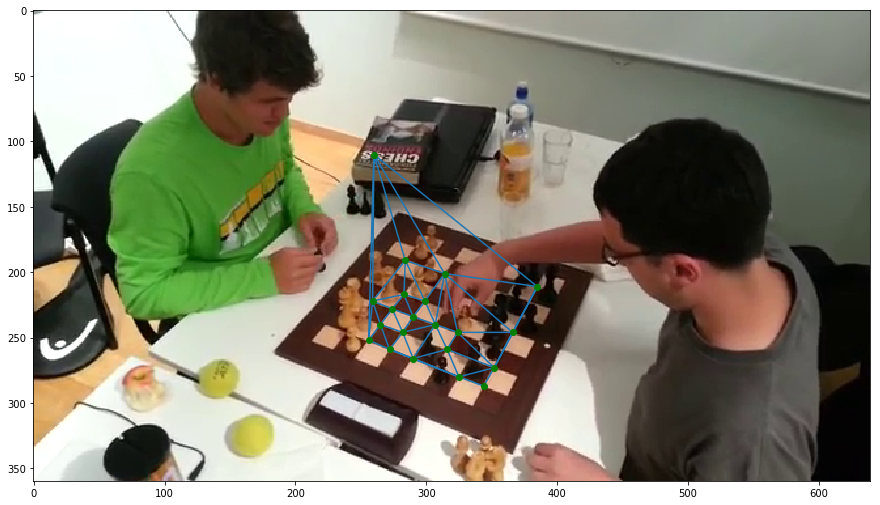

In [204]:
from scipy.spatial import Delaunay

tri = Delaunay(pts)
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy())
plt.plot(pts[:,0], pts[:,1], 'go')

Threshold: 28.4253
Good Simplices 391/33


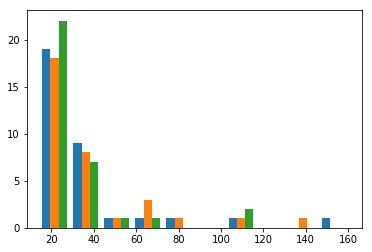

In [343]:
# print(dir(tri))
dists = np.zeros([tri.nsimplex, 3])
for i,triangle in enumerate(tri.points[tri.simplices]):
    # We want the distance of the edge opposite the vertex k, so r_k.
    r0 = (triangle[2,:] - triangle[1,:])
    r1 = (triangle[0,:] - triangle[2,:])
    r2 = (triangle[1,:] - triangle[0,:])
    dists[i,:] = np.linalg.norm(np.vstack([r0,r1,r2]), axis=1)
# print(dists)
plt.hist(dists)


threshold = 2*np.min(dists)
print("Threshold: %g" % threshold)
# Find edges that are too long (twice the median)
long_edges = dists > threshold
long_edged_simplices = np.any(long_edges,axis=1)
good_simplices = tri.simplices[~long_edged_simplices]
print("Good Simplices %d/%d" % (np.sum(good_simplices), tri.nsimplex))

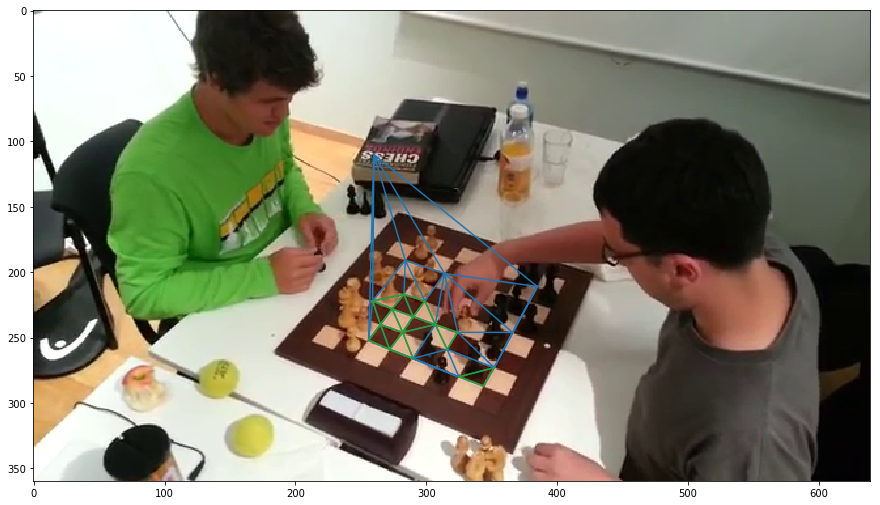

In [276]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy())
plt.triplot(pts[:,0], pts[:,1], good_simplices);
# plt.plot(pts[:,0], pts[:,1], 'go')

Idea to find quads from triangles. For each triangle, the triangle that completes the quad should always be on the longest edge of the triangle and shares the two vertices of that edge. No image gradient checks needed.

In [344]:
def removeOutlierSimplices(tri):
    dists = np.zeros([tri.nsimplex, 3])
    for i,triangle in enumerate(tri.points[tri.simplices]):
        # We want the distance of the edge opposite the vertex k, so r_k.
        r0 = (triangle[2,:] - triangle[1,:])
        r1 = (triangle[0,:] - triangle[2,:])
        r2 = (triangle[1,:] - triangle[0,:])
        dists[i,:] = np.linalg.norm(np.vstack([r0,r1,r2]), axis=1)
    # Threshold based on twice the smallest edge.
    threshold = 2*np.min(dists)
    # Find edges that are too long
    long_edges = dists > threshold
    long_edged_simplices = np.any(long_edges,axis=1)
    # Good simplices are those that don't contain any long edges
    good_simplices_mask = ~long_edged_simplices
#     good_simplices = tri.simplices[good_simplices_mask]
    return dists, good_simplices_mask

def findQuadSimplices(tri, dists, simplices_mask=None):
    vertex_idx_opposite_longest_edge = dists.argmax(axis=1)
    # The neighboring tri for each tri about the longest edge
    potential_neighbor = tri.neighbors[
        np.arange(tri.nsimplex),
        vertex_idx_opposite_longest_edge]
    good_neighbors = []
    for i,j in enumerate(potential_neighbor):
        if j == -1:
            # Skip those that don't have a neighbor
            continue
        # If these tris both agree that they're good neighbors, keep them.
        if (potential_neighbor[j] == i and i < j):
#             print(i,j)
            if simplices_mask is not None:
                if simplices_mask[i]:
                    good_neighbors.append(i)
                if simplices_mask[j]:
                    good_neighbors.append(j)
            else:
                good_neighbors.extend([i,j])
    return good_neighbors

In [345]:
# print(~long_edged_simplices)
dists, good_simplices_mask = removeOutlierSimplices(tri)
good_neighbors = findQuadSimplices(tri, dists, good_simplices_mask)
print(good_neighbors)

[17, 23, 24, 27, 26, 30]


In [340]:
# Find quads
good_neighbors = findQuadSimplices(tri, dists, ~long_edged_simplices)
print(good_neighbors)
print(tri.simplices[good_neighbors])

[17, 23, 24, 27, 26, 30]
[[ 9 15 14]
 [ 9 11 15]
 [11  9  7]
 [ 8 11  7]
 [ 8  7  4]
 [ 6  8  4]]


In [310]:
~long_edged_simplices

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True, False,  True,  True, False, False])

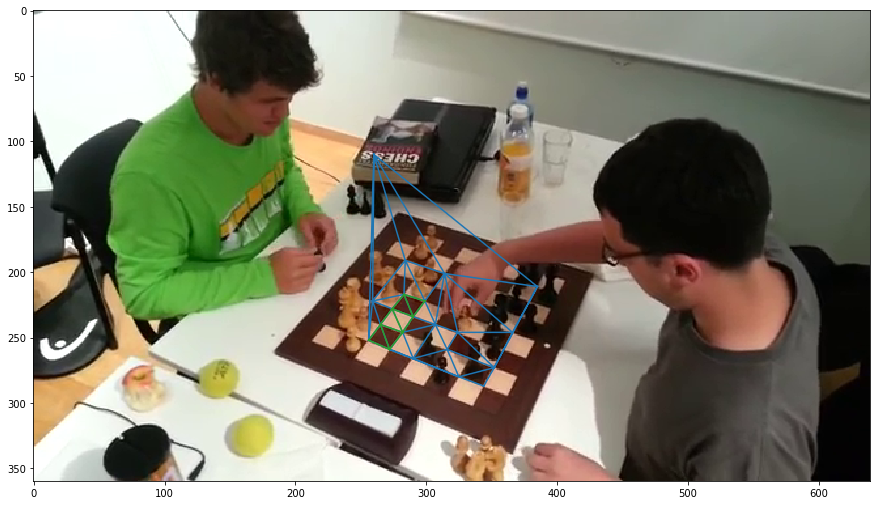

In [342]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy()) # All
# plt.triplot(pts[:,0], pts[:,1], good_simplices); # Potential
plt.triplot(pts[:,0], pts[:,1], tri.simplices[good_neighbors]); # Good neighbor pairs
# plt.plot(pts[:,0], pts[:,1], 'go')

In [183]:
%%time
tri = Delaunay(pts)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 634 µs


In [184]:
np.linalg.norm(pts.max(axis=0))

480.2020408119899

In [185]:
def uninformedHough(points, theta_bin_size=100, rho_bin_size=100):
    """Return uninformed hough space from points"""
    thetas = np.linspace(0,np.pi,theta_bin_size)
    max_rho = np.linalg.norm(pts.max(axis=0))
    rhos = np.linspace(0, max_rho,rho_bin_size) # length of diagonal
    hough_space = np.zeros([theta_bin_size, rho_bin_size], dtype=np.uint8)
    
    for i,j in pts:
        for t,theta in enumerate(thetas):
            rho = j*np.cos(theta) + i*np.sin(theta)
            rho_idx = np.searchsorted(rhos, rho) # Get bin index for rhos
            hough_space[t-1:t+2, rho_idx-1:rho_idx+2] += 1
            hough_space[t, rho_idx] += 1

    return (hough_space, thetas, rhos)

In [186]:
%%time
h, thetas, rhos = uninformedHough(pts, theta_bin_size=2*180, rho_bin_size=1*600)

CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 293 ms


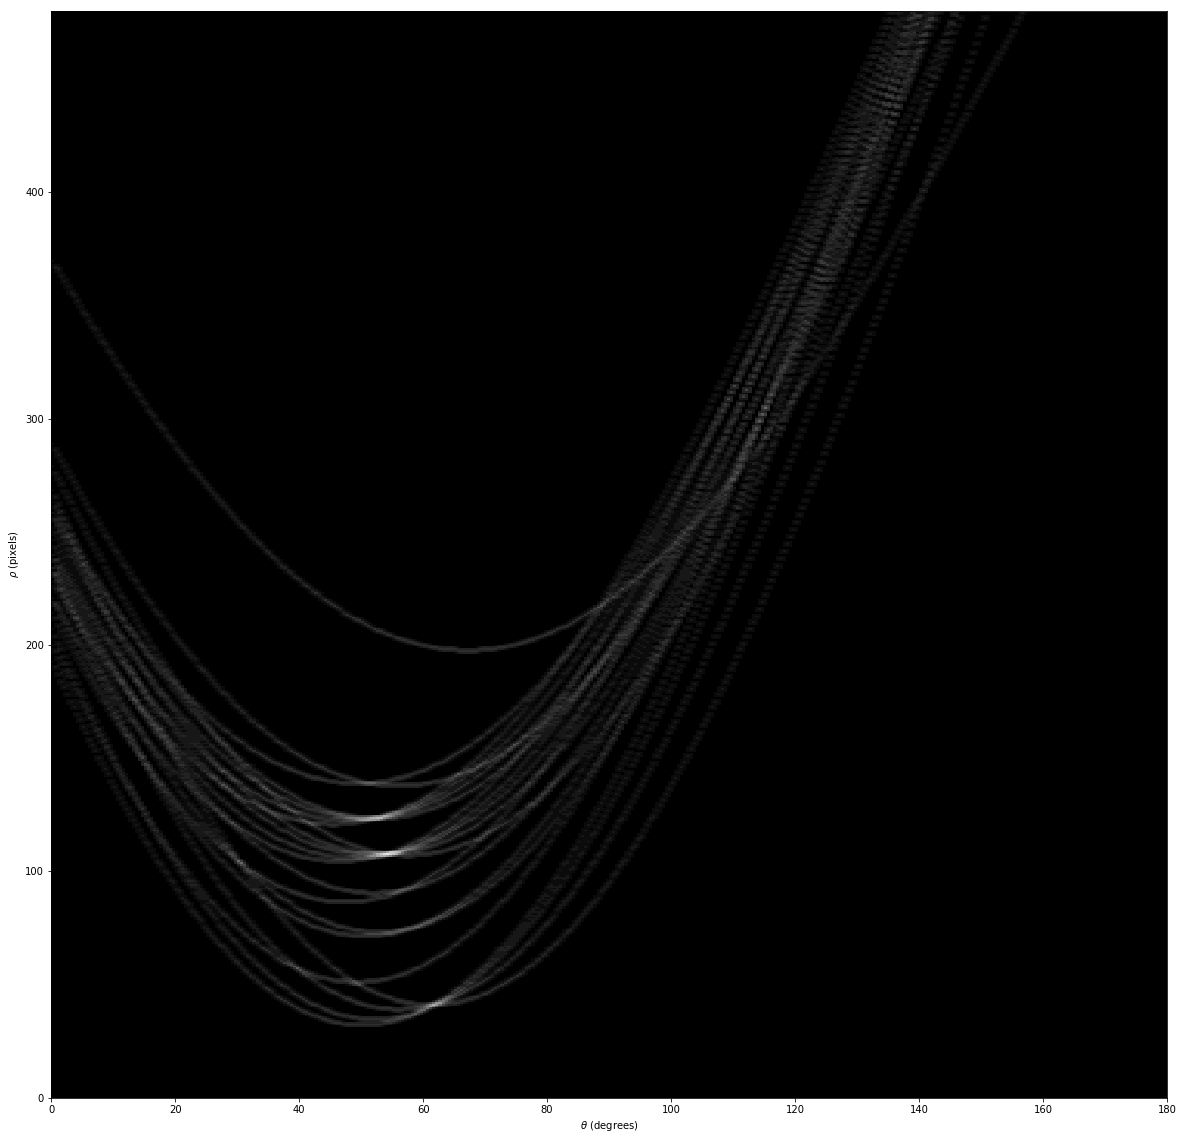

In [187]:
fig = plt.figure(figsize=(20,20))
plt.imshow(h.T, interpolation='none', extent=[thetas[0]*180/np.pi, thetas[-1]*180/np.pi, rhos[0], rhos[-1]], cmap=cm.gray)
plt.xlabel(r'$\theta}$ (degrees)')
plt.ylabel(r'$\rho}$ (pixels)')
plt.axis('normal')
plt.axis('tight');

In [188]:
def fast_nonmax_sup(img_in, win=21):
    img = img_in.copy()
    element = np.ones([win, win], np.uint8)
#     img = cv2.blur(img, (5,5))
    img_dilate = cv2.dilate(img, element)
    peaks = cv2.compare(img, img_dilate, cv2.CMP_EQ)
    # nonzeroImg = cv2.compare(img, 0, cv2.CMP_NE)
    # peaks = cv2.bitwise_and(peaks, nonzeroImg)
    # peaks[img == 0] = 0
    # notPeaks = cv2.bitwise_not(peaks)

    img[peaks == 0] = 0
    return img

In [189]:
h_peaks = h.copy()
h_peaks[h_peaks<3] = 0
h_peaks = fast_nonmax_sup(h_peaks)

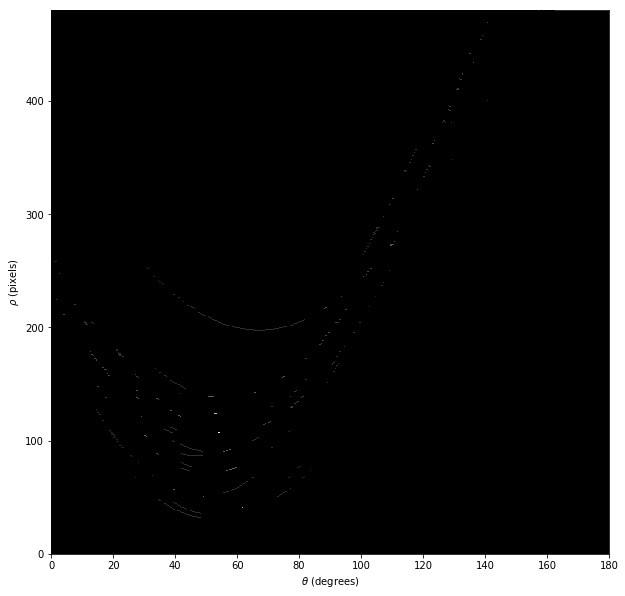

In [190]:
fig = plt.figure(figsize=(10,10))
plt.imshow(h_peaks.T, interpolation='none', extent=[thetas[0]*180/np.pi, thetas[-1]*180/np.pi, rhos[0], rhos[-1]], cmap=cm.gray)
plt.xlabel(r'$\theta}$ (degrees)')
plt.ylabel(r'$\rho}$ (pixels)')
plt.axis('normal')
plt.axis('tight');

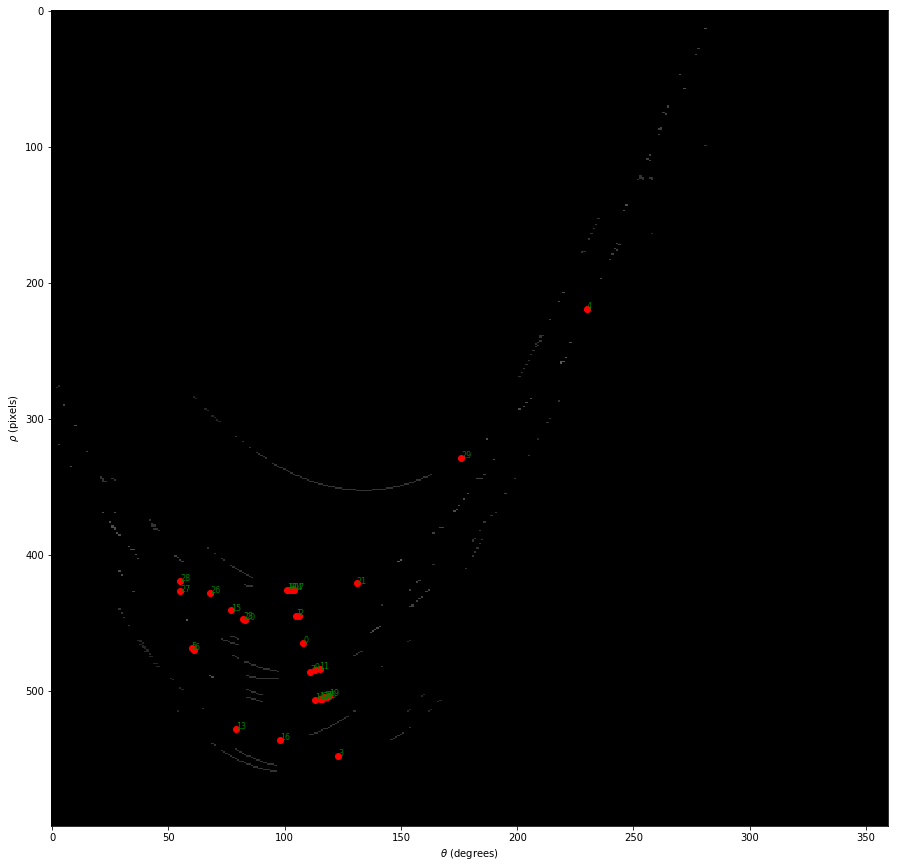

In [191]:
h_peaks[:,:10] = 0
pot_vals = np.argwhere(h_peaks)
pot_scores = h_peaks[pot_vals[:,0], pot_vals[:,1]]
pot_order = np.argsort(pot_scores)[::-1]

pot_pts_ordered = pot_vals[pot_order,:]
pot_scores_ordered = pot_scores[pot_order]
n_peaks = 30


fig = plt.figure(figsize=(15,15))
plt.imshow(h_peaks.T, interpolation='none', cmap=cm.gray)
plt.plot(pot_pts_ordered[:n_peaks,0], pot_pts_ordered[:n_peaks, 1], 'or')
plt.xlabel(r'$\theta}$ (degrees)')
plt.ylabel(r'$\rho}$ (pixels)')
plt.axis('normal')
plt.axis('tight');

for idx, (px, py) in enumerate(pot_pts_ordered[:n_peaks,:]):
    plt.text(px, py,'%s' % idx, color='green', size=8)


In [192]:
def getHoughLines(peaks, thetas, rhos, img_shape):
    # lines segments within image bounds x1 y1 x2 y2
    lines = np.zeros([peaks.shape[0],4])
    
    for i, [theta_, rho_] in enumerate(peaks):
        theta = thetas[theta_]
        rho = rhos[rho_]
        c = np.cos(theta)
        s = np.sin(theta)
        
        img_x_max = img_shape[1]-1
        img_y_max = img_shape[0]-1
#         print("sin:",s)
#         print("cos:",c)
#         print(theta*180/np.pi,rho)

        if np.abs(c) < np.abs(s):
            # angle is closer to 0 or 180 degrees, horizontal line so use x limits
#             print("H")
            x1 = 0
            x2 = img_x_max
            y1 = (rho - x1*c)/s
            y2 = (rho - x2*c)/s
        else:
            # angle closer to 90 degrees, vertical line so use y limits
#             print("V")
            y1 = 0
            y2 = img_y_max
            x1 = (rho - y1*s)/c
            x2 = (rho - y2*s)/c
        
#         print(x1, y1, x2, y2)

        # Get line ends within image bounds
        # TODO : Fails on very close to vertical/horizontal lines due to divide by ~zero
        if (np.abs(s) > 0.01 and np.abs(c) > 0.01):
            if (y1 < 0):
                x1 = (rho - 0*s)/c
                y1 = (rho - x1*c)/s
            elif (y1 > img_y_max):
                x1 = (rho - img_y_max*s)/c
                y1 = (rho - x1*c)/s
            if (y2 < 0):
                x2 = (rho - 0*s)/c
                y2 = (rho - x2*c)/s
            elif (y2 > img_y_max):
                x2 = (rho - img_y_max*s)/c
                y2 = (rho - x2*c)/s

            if (x1 < 0):
                y1 = (rho-0*c)/s
                x1 = (rho - y1*s)/c
            elif (x1 > img_x_max):
                y1 = (rho - img_x_max*c)/s
                x1 = (rho - y1*s)/c
            if (x2 < 0):
                y2 = (rho-0*c)/s
                x2 = (rho - y2*s)/c
            elif (x2 > img_x_max):
                y2 = (rho - img_x_max*c)/s
                x2 = (rho - y2*s)/c

        lines[i,:] = [x1, y1, x2, y2]

    return lines

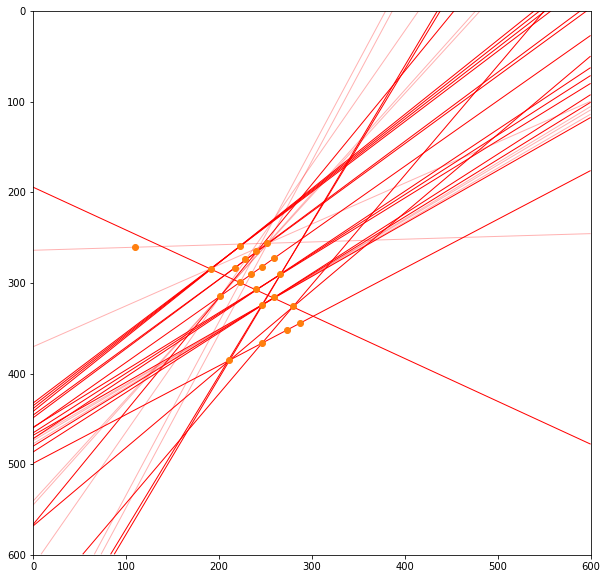

In [193]:
fig = plt.figure(figsize=(10,10))
# plt.imshow(img_orig);
plt.plot(pts[:,1],pts[:,0],'.')
plt.axis([0,600,600,0])

lines = getHoughLines(pot_pts_ordered[:n_peaks,:], thetas, rhos, [600,600])

for i, [x1,y1,x2,y2] in enumerate(lines):
#     alpha_ = 1.0 if i < min(peaks.shape[0],20) else 0.3 # Make first 20 lines strongest
    alpha_ = 1.0 if i < 20 else 0.3
    plt.plot([x1,x2], [y1,y2],'r-', alpha=alpha_, lw=1)
    
plt.plot(pts[:,1],pts[:,0],'o')